In [1]:
from plane_cylinder_projections import *
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2


torch.Size([2, 80])


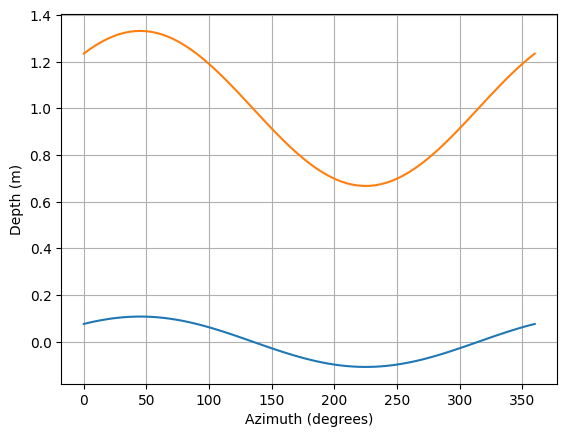

In [11]:
azimuth_coordinates_phi = torch.linspace(0, 2*torch.pi, 80).unsqueeze(0)
azimuth_coordinates_phi = azimuth_coordinates_phi.repeat(2, 1)
# print(azimuth_coordinates_phi.shape)
plane_angle = torch.tensor(
    [
        [torch.pi/4, torch.pi/4, 0.],
        [0.8*torch.pi/2., torch.pi/4, 1.],
    ]
)
altitude_z = intersect_plane_with_cyliner(azimuth_coordinates_phi, plane_angle)
print(altitude_z.shape)


In [12]:
p3D = angle_to_3d_vector(azimuth_coordinates_phi, altitude_z=altitude_z) # [N, L, 3]

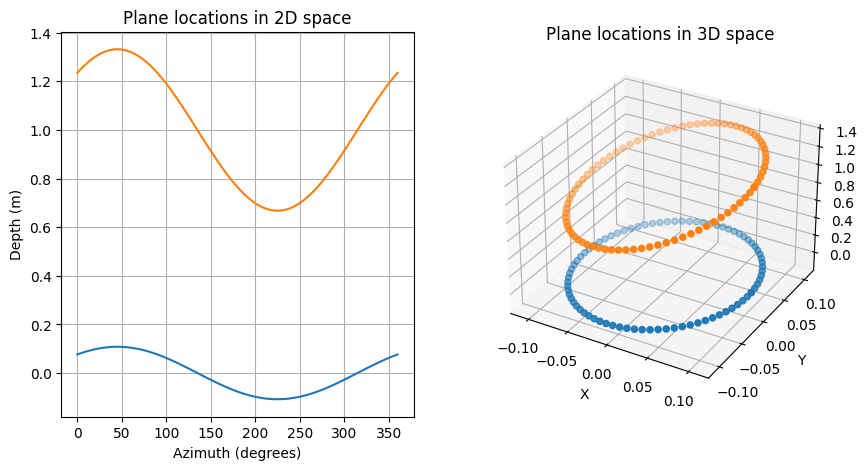

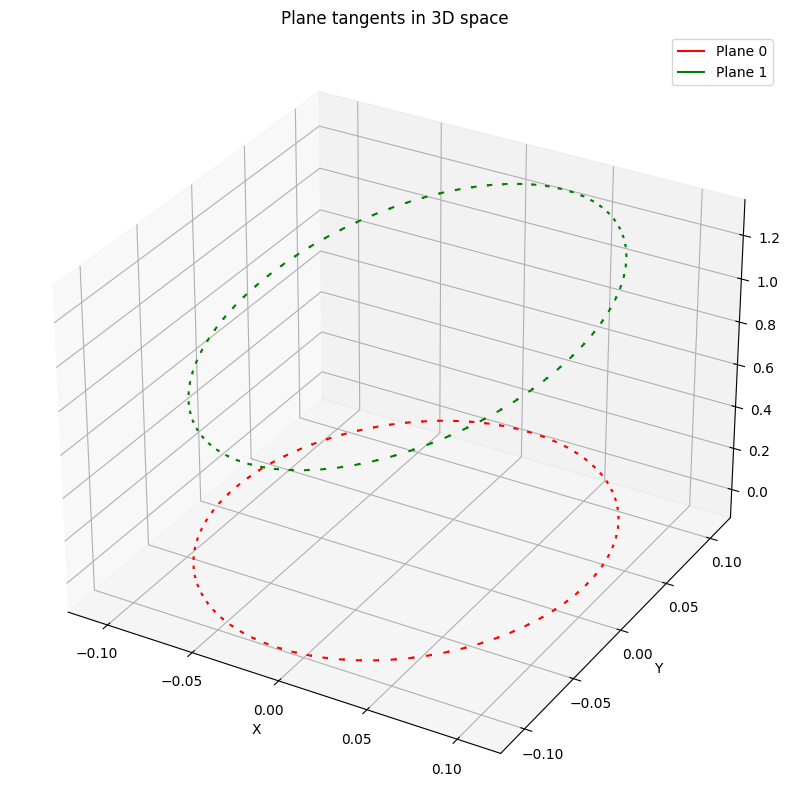

In [20]:
# Plotting
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121)
# ----------------- 2D plot -----------------
ax.plot(torch.rad2deg(azimuth_coordinates_phi.T), altitude_z.T)
ax.set_xlabel("Azimuth (degrees)")
ax.set_ylabel("Depth (m)")
ax.grid()
ax.set_title('Plane locations in 2D space')
# plt.show()

# ----------------- 3D plot -----------------

ax = fig.add_subplot(122, projection='3d')

# Extract x, y, z coordinates for plotting
for batch_index in range(p3D.shape[0]):
    x_coords, y_coords, z_coords = p3D[batch_index, :, 0], p3D[batch_index, :, 1], p3D[batch_index, :, 2]
    ax.scatter(x_coords, y_coords, z_coords, label=f"Plane {batch_index}")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Plane locations in 3D space')
plt.show()

# ----------------- 3D quiver -----------------
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
colors = ['r', 'g', 'b', 'y']
# Extract x, y, z coordinates for plotting
t3d = (p3D[..., 1:, :] - p3D[..., :-1, :])/3.
for batch_index in range(p3D.shape[0]):
    x_coords, y_coords, z_coords = p3D[batch_index, :-1, 0], p3D[batch_index, :-1, 1], p3D[batch_index, :-1, 2]
    tangent3d_x, tangent3d_y, tangent3d_z = t3d[batch_index, :, 0], t3d[batch_index, :, 1], t3d[batch_index, :, 2]
    ax.quiver(x_coords, y_coords, z_coords, tangent3d_x, tangent3d_y, tangent3d_z,
              color=colors[batch_index%len(colors)],
              arrow_length_ratio=0.2,
              label=f"Plane {batch_index}")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.legend()
ax.set_title('Plane tangents in 3D space')
plt.show()

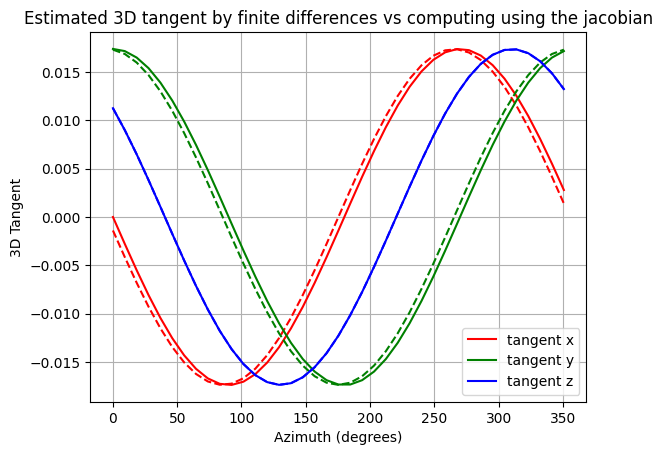

In [7]:
batch_idx, element_idx = 0, 0
# There's no obvious way to compute the jacobian per batch element, so ... loop over the elements
# There's a hacky solution proposed in pytorch forums, but it's not clear if it's correct
# https://discuss.pytorch.org/t/computing-batch-jacobian-efficiently/80771
estimated_grad_list = []
tangent3d = (p3D[..., 1:, :] - p3D[..., :-1, :])
for element_idx in range(azimuth_coordinates_phi.shape[1]-1):
    azi, alt = azimuth_coordinates_phi[batch_idx, element_idx], altitude_z[batch_idx, element_idx]
    delta_azi = azimuth_coordinates_phi[batch_idx, element_idx+1] - azimuth_coordinates_phi[batch_idx, element_idx]
    delta_alt = altitude_z[batch_idx, element_idx+1] - altitude_z[batch_idx, element_idx]
    estimated_grad = image_vector_to_3d_plane_tangent(azi, alt, delta_azi, delta_alt)
    estimated_grad_list.append(estimated_grad)
estimated_grad_list = torch.stack(estimated_grad_list)
for dim_idx, dim_name, dim_color  in zip(range(3), "xyz", "rgb"):
    plt.plot(torch.rad2deg(azimuth_coordinates_phi[batch_idx,:-1]), estimated_grad_list[:, dim_idx], color=dim_color, label=f"tangent {dim_name}")
    plt.plot(torch.rad2deg(azimuth_coordinates_phi[batch_idx,:-1]), tangent3d[0,  :, dim_idx], "--", color=dim_color)
plt.xlabel("Azimuth (degrees)")
plt.ylabel("3D Tangent")
plt.legend()
plt.grid()
plt.title("Estimated 3D tangent by finite differences vs computing using the jacobian")
plt.show()